# Diffusion mapping tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from ukat.data import fetch
from ukat.mapping.diffusion import ADC, DTI

# Ensure figures are rendered in the notebook
%matplotlib inline

Tell python where to store the maps NIfTI files we will generate. We will store it in a directory called
`diffusion_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for diffusion maps
directory = 'diffusion_calculation_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

Retrieve diffusion test data using our data fetcher.
This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `bvals`: an array containing the degree of diffusion weighting of each volume, measured in s/mm$^2$.
* `bvecs` : an array containing the vectors defining the direction the corresponding `bval` is applied.

In [3]:
# Fetch test data
pixel_array, affine, bvals, bvecs = fetch.dwi_philips()
# Generate a mask based on the intensity of the b-0 volume. This will reduce computation times
mask = pixel_array[..., 0] > 20000

`UKAT` contains two diffusion analysis methods, `ADC` (Apparent Diffusion Coefficient) and `DTI` (Diffusion Tensor Imaging).

The `ADC` class fits data to $S = S_0e^{-b \cdot ADC}$ to estimate $ADC$ and therefore does not consider the directionality
of diffusion within tissue. As such, the directional effects of diffusion are mitigated by averaging data collected at
each b-value in multiple directions.

`DTI` uses the combination of b-values, b-vectors and signal to estimate the diffusion tensor, $\mathscr{D}$, where

$\mathscr{D} =
	\begin{bmatrix}
		D_{xx} & D_{xy} & D_{xz}\\
		D_{yx} & D_{yy} & D_{yz}\\
		D_{zx} & D_{zy} & D_{zz}
	\end{bmatrix}$

The eigenvalues of this tensor ($\lambda_1$, $\lambda_2$ & $\lambda_3$) can then be used to estimate Mean Diffusivity ($MD$)
and Fractional Anisotropy ($FA$) where $MD = \frac{\left( \lambda_1 + \lambda_2 + \lambda_3 \right)}{3}$ and $FA =
\sqrt{\frac{\left(\lambda_1 - \lambda_2\right)^2 + \left(\lambda_2 - \lambda_3\right)^2 + \left(\lambda_1 - \lambda_3\right)
^2}{2\left( \lambda_1^2 + \lambda_2^2 + \lambda_3^2\right)}}$. The DTI class is a streamlined/simplified interface for [dipy]
(https://dipy.org/).

In this tutorial we will generate an ADC, MD and FA map.

In [4]:
# Calculate maps using ADC methods and save as niftis
adc_mapper = ADC(pixel_array, affine, bvals, bvecs, mask)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion', maps='all')

# Calculate maps using DTI methods and save as niftis
dti_mapper = DTI(pixel_array, affine, bvals, bvecs, mask)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion', maps=['md', 'fa'])

100%|██████████| 57520/57520 [00:08<00:00, 6726.19it/s]


(-0.5, 127.5, 127.5, -0.5)

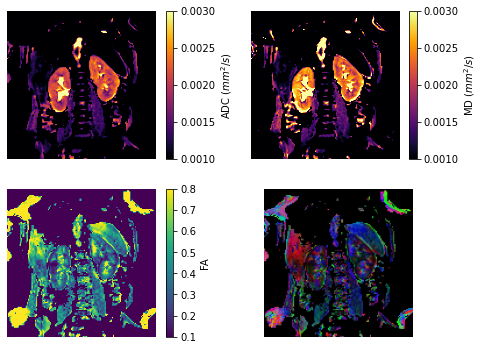

In [5]:
# Display the central slice of each map
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Display a central slice of the ADC map
im = ax[0, 0].imshow(np.rot90(adc_mapper.adc[:, :, adc_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('ADC ($mm^2/s$)')
ax[0, 0].axis('off')

# Display a central slice of the MD map
im = ax[0, 1].imshow(np.rot90(dti_mapper.md[:, :, dti_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('MD ($mm^2/s$)')
ax[0, 1].axis('off')

# Display a central slice of the FA map
im = ax[1, 0].imshow(np.rot90(dti_mapper.fa[:, :, dti_mapper.shape[2]//2]), cmap='viridis', clim=(0.1, 0.8))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('FA')
ax[1, 0].axis('off')

# Display a central slice of the color FA map
im = ax[1, 1].imshow(np.rot90(dti_mapper.color_fa[:, :, dti_mapper.shape[2]//2, :]))
ax[1, 1].axis('off')

ADC and MD maps measure the same underlying properties of the tissue, as such we can see how closely correlated these two
analysis method are using a 2D histogram/hexbin plot.

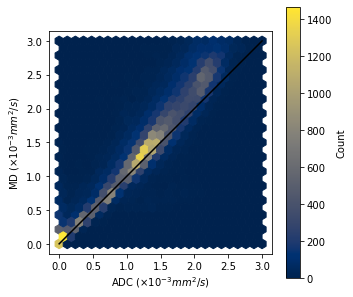

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.hexbin(adc_mapper.adc[mask] * 1000, dti_mapper.md[mask] * 1000, gridsize=25, extent=(0, 3, 0, 3), cmap='cividis')
cb = fig.colorbar(im, ax=ax)
cb.set_label('Count')
ax.plot([0, 3], [0, 3], color='0')
ax.set_xlabel(r'ADC ($\times 10^{-3} mm^2/s$)')
ax.set_ylabel(r'MD ($\times 10^{-3} mm^2/s$)')
ax.set_aspect(1)